# San Ramon Rents Using MXNet

In this tutorial we'll walk through how to predict San Ramon rents using *linear regression* with MXNet.

The rents data is based on <https://sfbay.craigslist.com>


## San Ramon, California

<img height=500 src="https://cdn.tollbrothers.com/communities/12871/images/2880BiancoExterior_920.jpg">

## Prerequisites

To complete this tutorial, we need:  

- jupyter
- scikitlearn
- pandas
- numpy
- matplotlib
- mxnet

## Imports

To begin, the following code imports the necessary packages we'll need for this exercise.

In [1]:
import mxnet as mx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Fix the random seed
mx.random.seed(2727)

import logging
logging.getLogger().setLevel(logging.DEBUG)

## Preparing the Data

In MXNet, data is input via **Data Iterators**. Here we will illustrate
how to encode a dataset into an iterator that MXNet can use. The data used in the example is made up of 2D data points with corresponding integer labels. 

In [3]:
# Get the rents as a data frame.
rents_csv = "san-ramon-rents.csv"
df = pd.read_csv(rents_csv)

In [4]:
# What does the data look like?
df.head()

,rent,br,ft2
0,2350.0,2.0,924.0
1,1981.0,1.0,712.0
2,2155.0,1.0,625.0
3,2125.0,1.0,689.0
4,1989.0,1.0,689.0


In [5]:
# What are the min/max/avg of the features?
df.describe()

,rent,br,ft2
count,256.000000,256.000000,256.000000
mean,2787.437500,2.175781,1179.835938
std,878.821057,0.943689,642.734242
min,1800.000000,1.000000,400.000000
25%,2300.000000,2.000000,800.000000
50%,2575.000000,2.000000,953.000000
75%,2961.250000,3.000000,1253.500000
max,9500.000000,5.000000,5200.000000


## Visualize

The first thing to do when you get a new data set is to visualize it and develop some intuition about it.

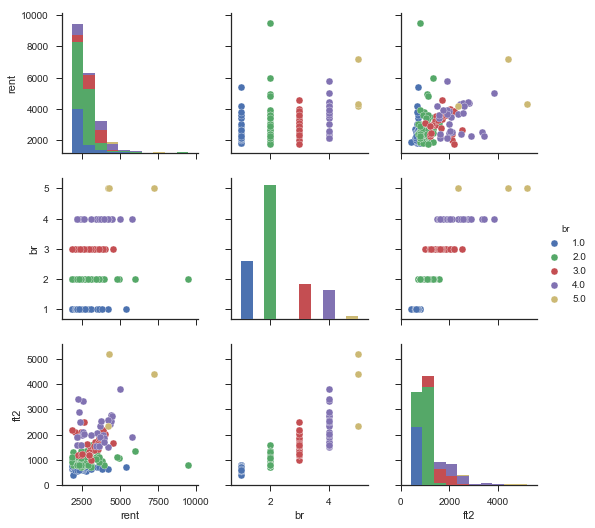

In [6]:
# Create a scatter matrix to figure out relationships between features and label.
sns.set(style="ticks")
sns.pairplot(df,hue='br')
plt.show()

## Preparation

Before we build and model and test it, we need to set things up. We want to split our data into a training set and a test set. This way we can evaluate our model objectively.

In [7]:
# Split the data into features (X) and label (y)
label_column = 'rent'
X = df.drop(label_column, axis=1)
y = df[label_column]

# Split data set into training and test sets.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

# Since ft2 is much larger than br we can scale to standardize the features.
scale_features = True
if scale_features:
    # Scale features automatically extracts feature numpy arrays.
    from sklearn import preprocessing
    std_scale = preprocessing.StandardScaler().fit(X_train)
    X_train = std_scale.transform(X_train)
    X_test = std_scale.transform(X_test)
else:
    # Extract feature numpy arrays.
    X_train = X_train.values
    X_test = X_test.values

# Extract label numpy arrays.
y_train = y_train.values
y_test = y_test.values
        
# How many examples do we train on at a time.
batch_size = 30

Once we have the data ready, we need to put it into an iterator and specify
parameters such as `batch_size` and `shuffle`. `batch_size` specifies the number
of examples shown to the model each time we update its parameters and `shuffle`
tells the iterator to randomize the order in which examples are shown to the model.

In [8]:
train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True, label_name='lin_reg_label')
eval_iter = mx.io.NDArrayIter(X_test, y_test, batch_size, shuffle=False, label_name='lin_reg_label')

In the above example, we have made use of `NDArrayIter`, which is useful for iterating
over both numpy ndarrays and MXNet NDArrays. In general, there are different types of iterators in
MXNet and you can use one based on the type of data you are processing.
Documentation for iterators can be found [here](http://mxnet.io/api/python/io/io.html).

## MXNet Classes

1. **IO:** The IO class as we already saw works on the data and carries out
   operations such as feeding data in batches and shuffling.
   
2. **Symbol:** The actual MXNet neural network is composed using symbols. MXNet has
   different types of symbols, including variable placeholders for input data,
   neural network layers, and operators that manipulate NDArrays.

3. **Module:** The module class in MXNet is used to define the overall computation.
	It is initialized with the model we want to train, the training inputs (data and labels)
	and some additional parameters such as learning rate and the optimization
	algorithm to use.

## Defining the Model

MXNet uses **Symbols** for defining a model. Symbols are the building blocks 
and make up various components of the model. Symbols are used to define:

1. **Variables:** A variable is a placeholder for future data. This symbol is used
   to define a spot which will be filled with training data/labels in the future
   when we commence training.
2. **Neural Network Layers:** The layers of a network or any other type of model are
   also defined by Symbols. Such a symbol takes one or more previous symbols as
   inputs, performs some transformations on them, and creates one or more outputs.
   One such example is the `FullyConnected` symbol which specifies a fully connected
   layer of a neural network.
3. **Outputs:** Output symbols are MXNet's way of defining a loss. They are
   suffixed with the word "Output" (eg. the `SoftmaxOutput` layer). You can also
   [create your own loss function](https://github.com/dmlc/mxnet/blob/master/docs/tutorials/r/CustomLossFunction.md#how-to-use-your-own-loss-function).
   Some examples of existing losses are: `LinearRegressionOutput`, which computes
   the l2-loss between it's input symbol and the labels provided to it;
   `SoftmaxOutput`, which computes the categorical cross-entropy.

The ones described above and other symbols are chained together with the output of
one symbol serving as input to the next to build the network topology. More information
about the different types of symbols can be found [here](http://mxnet.io/api/python/symbol/symbol.html).

In [9]:
X = mx.sym.Variable('data')
Y = mx.symbol.Variable('lin_reg_label')
fully_connected_layer  = mx.sym.FullyConnected(data=X, name='fc1', num_hidden = 1)
lro = mx.sym.LinearRegressionOutput(data=fully_connected_layer, label=Y, name="lro")

The above network uses the following layers:

1. `FullyConnected`: The fully connected symbol represents a fully connected layer
   of a neural network (without any activation being applied), which in essence,
   is just a linear regression on the input attributes. It takes the following
   parameters:

   - `data`: Input to the layer (specifies the symbol whose output should be fed here)
   - `num_hidden`: Number of hidden neurons in the layer, which is same as the dimensionality
     of the layer's output

2. `LinearRegressionOutput`: Output layers in MXNet compute training loss, which is
	the measure of inaccuracy in the model's predictions. The goal of training is to minimize the
	training loss. In our example, the `LinearRegressionOutput` layer computes the *l2* loss against
	its input and the labels provided to it. The parameters to this layer are:

   - `data`: Input to this layer (specifies the symbol whose output should be fed here)
   - `label`: The training labels against which we will compare the input to the layer for calculation of l2 loss

## Visualize Network

We can visualize the network we created by plotting it:

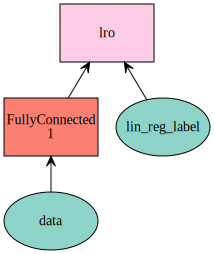

In [10]:
mx.viz.plot_network(symbol=lro)

**Note on naming convention:** the label variable's name should be the same as the
`label_name` parameter passed to your training data iterator. The default value of
this is `softmax_label`, but we have updated it to `lin_reg_label` in this
tutorial as you can see in `Y = mx.symbol.Variable('lin_reg_label')` and
`train_iter = mx.io.NDArrayIter(..., label_name='lin_reg_label')`.


## Module

Finally, the network is input to a *Module*, where we specify the symbol
whose output needs to be minimized (in our case, `lro` or the `lin_reg_output`), the
learning rate to be used while optimization and the number of epochs we want to
train our model for.

In [11]:
# Network structure.
model = mx.mod.Module(
    symbol = lro ,
    data_names=['data'],
    label_names = ['lin_reg_label']
)

In [12]:
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label) 
init = mx.init.Uniform(0.1)
model.init_params(init)

## Training the model

Once we have defined the model structure, the next step is to train the
parameters of the model to fit the training data. This is accomplished using the
`fit()` function of the `Module` class.

Speedometer determines how often we get a callback during training with error data. We will be called every 2 batches if the second argument is 2.

In [13]:
model.fit(train_iter, eval_iter,
            optimizer = "adam",
            optimizer_params = {'learning_rate': 8.0},
            num_epoch=800,
            eval_metric='rmse',
            batch_end_callback = mx.callback.Speedometer(batch_size, 2))

/Users/asimjali/Library/Python/2.7/lib/python/site-packages/mxnet/module/base_module.py:464: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  allow_missing=allow_missing, force_init=force_init)
INFO:root:Epoch[0] Batch [2]	Speed: 19789.12 samples/sec	rmse=2867.160319
INFO:root:Epoch[0] Batch [4]	Speed: 16225.55 samples/sec	rmse=2855.151367
INFO:root:Epoch[0] Train-rmse=3259.666016
INFO:root:Epoch[0] Time cost=0.019
INFO:root:Epoch[0] Validation-rmse=2769.119954
INFO:root:Epoch[1] Batch [2]	Speed: 15325.39 samples/sec	rmse=2814.852295
INFO:root:Epoch[1] Batch [4]	Speed: 17646.61 samples/sec	rmse=2792.487671
INFO:root:Epoch[1] Train-rmse=3213.865479
INFO:root:Epoch[1] Time cost=0.014
INFO:root:Epoch[1] Validation-rmse=2737.465088
INFO:root:Epoch[2] Batch [2]	Speed: 26420.81 samples/sec	rmse=2764.918864
INFO:root:Epoch[2] Batch [4]	Speed: 20811.96 samples/sec	rmse=2730.760742
INFO:root:Epoch[2] Train-rmse=3168.787842
INFO:root:Epoch[2] Time cos

INFO:root:Epoch[28] Validation-rmse=1803.894409
INFO:root:Epoch[29] Batch [2]	Speed: 17074.31 samples/sec	rmse=1662.740641
INFO:root:Epoch[29] Batch [4]	Speed: 20443.40 samples/sec	rmse=1558.945862
INFO:root:Epoch[29] Train-rmse=2209.523926
INFO:root:Epoch[29] Time cost=0.014
INFO:root:Epoch[29] Validation-rmse=1771.768962
INFO:root:Epoch[30] Batch [2]	Speed: 21747.17 samples/sec	rmse=1629.244832
INFO:root:Epoch[30] Batch [4]	Speed: 19194.44 samples/sec	rmse=1525.735718
INFO:root:Epoch[30] Train-rmse=2182.269043
INFO:root:Epoch[30] Time cost=0.015
INFO:root:Epoch[30] Validation-rmse=1740.199504
INFO:root:Epoch[31] Batch [2]	Speed: 21135.32 samples/sec	rmse=1596.298462
INFO:root:Epoch[31] Batch [4]	Speed: 17069.68 samples/sec	rmse=1493.091919
INFO:root:Epoch[31] Train-rmse=2155.621338
INFO:root:Epoch[31] Time cost=0.013
INFO:root:Epoch[31] Validation-rmse=1709.194377
INFO:root:Epoch[32] Batch [2]	Speed: 18214.99 samples/sec	rmse=1563.905029
INFO:root:Epoch[32] Batch [4]	Speed: 20769.02 

INFO:root:Epoch[58] Train-rmse=1654.355469
INFO:root:Epoch[58] Time cost=0.017
INFO:root:Epoch[58] Validation-rmse=1093.126444
INFO:root:Epoch[59] Batch [2]	Speed: 27336.33 samples/sec	rmse=903.610575
INFO:root:Epoch[59] Batch [4]	Speed: 12476.86 samples/sec	rmse=817.210571
INFO:root:Epoch[59] Train-rmse=1643.042236
INFO:root:Epoch[59] Time cost=0.015
INFO:root:Epoch[59] Validation-rmse=1078.304606
INFO:root:Epoch[60] Batch [2]	Speed: 18755.27 samples/sec	rmse=887.051331
INFO:root:Epoch[60] Batch [4]	Speed: 17905.25 samples/sec	rmse=801.679321
INFO:root:Epoch[60] Train-rmse=1632.162964
INFO:root:Epoch[60] Time cost=0.014
INFO:root:Epoch[60] Validation-rmse=1064.010254
INFO:root:Epoch[61] Batch [2]	Speed: 19030.42 samples/sec	rmse=871.031840
INFO:root:Epoch[61] Batch [4]	Speed: 24331.26 samples/sec	rmse=786.724823
INFO:root:Epoch[61] Train-rmse=1621.706177
INFO:root:Epoch[61] Time cost=0.011
INFO:root:Epoch[61] Validation-rmse=1050.235636
INFO:root:Epoch[62] Batch [2]	Speed: 32965.45 sa

INFO:root:Epoch[88] Train-rmse=1460.261841
INFO:root:Epoch[88] Time cost=0.015
INFO:root:Epoch[88] Validation-rmse=837.464213
INFO:root:Epoch[89] Batch [2]	Speed: 26880.82 samples/sec	rmse=609.761678
INFO:root:Epoch[89] Batch [4]	Speed: 23058.30 samples/sec	rmse=565.606323
INFO:root:Epoch[89] Train-rmse=1457.426880
INFO:root:Epoch[89] Time cost=0.012
INFO:root:Epoch[89] Validation-rmse=833.935425
INFO:root:Epoch[90] Batch [2]	Speed: 27893.84 samples/sec	rmse=605.643636
INFO:root:Epoch[90] Batch [4]	Speed: 10355.45 samples/sec	rmse=562.962128
INFO:root:Epoch[90] Train-rmse=1454.735229
INFO:root:Epoch[90] Time cost=0.016
INFO:root:Epoch[90] Validation-rmse=830.608968
INFO:root:Epoch[91] Batch [2]	Speed: 33407.44 samples/sec	rmse=601.771403
INFO:root:Epoch[91] Batch [4]	Speed: 20746.76 samples/sec	rmse=560.541077
INFO:root:Epoch[91] Train-rmse=1452.180542
INFO:root:Epoch[91] Time cost=0.013
INFO:root:Epoch[91] Validation-rmse=827.475159
INFO:root:Epoch[92] Batch [2]	Speed: 22098.55 sample

INFO:root:Epoch[118] Batch [4]	Speed: 27395.85 samples/sec	rmse=542.212616
INFO:root:Epoch[118] Train-rmse=1416.576050
INFO:root:Epoch[118] Time cost=0.009
INFO:root:Epoch[118] Validation-rmse=788.123759
INFO:root:Epoch[119] Batch [2]	Speed: 37854.73 samples/sec	rmse=555.365885
INFO:root:Epoch[119] Batch [4]	Speed: 26846.41 samples/sec	rmse=542.324936
INFO:root:Epoch[119] Train-rmse=1416.008667
INFO:root:Epoch[119] Time cost=0.011
INFO:root:Epoch[119] Validation-rmse=787.613118
INFO:root:Epoch[120] Batch [2]	Speed: 29167.62 samples/sec	rmse=554.916372
INFO:root:Epoch[120] Batch [4]	Speed: 23924.16 samples/sec	rmse=542.452240
INFO:root:Epoch[120] Train-rmse=1415.471191
INFO:root:Epoch[120] Time cost=0.010
INFO:root:Epoch[120] Validation-rmse=787.135437
INFO:root:Epoch[121] Batch [2]	Speed: 31964.72 samples/sec	rmse=554.503408
INFO:root:Epoch[121] Batch [4]	Speed: 22988.79 samples/sec	rmse=542.592468
INFO:root:Epoch[121] Train-rmse=1414.962280
INFO:root:Epoch[121] Time cost=0.011
INFO:ro

INFO:root:Epoch[147] Time cost=0.019
INFO:root:Epoch[147] Validation-rmse=781.293498
INFO:root:Epoch[148] Batch [2]	Speed: 42617.82 samples/sec	rmse=550.442983
INFO:root:Epoch[148] Batch [4]	Speed: 24612.05 samples/sec	rmse=546.988617
INFO:root:Epoch[148] Train-rmse=1407.960083
INFO:root:Epoch[148] Time cost=0.011
INFO:root:Epoch[148] Validation-rmse=781.214518
INFO:root:Epoch[149] Batch [2]	Speed: 35064.55 samples/sec	rmse=550.410126
INFO:root:Epoch[149] Batch [4]	Speed: 15544.05 samples/sec	rmse=547.105164
INFO:root:Epoch[149] Train-rmse=1407.850586
INFO:root:Epoch[149] Time cost=0.012
INFO:root:Epoch[149] Validation-rmse=781.140259
INFO:root:Epoch[150] Batch [2]	Speed: 27348.21 samples/sec	rmse=550.380208
INFO:root:Epoch[150] Batch [4]	Speed: 22314.08 samples/sec	rmse=547.217194
INFO:root:Epoch[150] Train-rmse=1407.747192
INFO:root:Epoch[150] Time cost=0.015
INFO:root:Epoch[150] Validation-rmse=781.070292
INFO:root:Epoch[151] Batch [2]	Speed: 23565.71 samples/sec	rmse=550.352936
INF

INFO:root:Epoch[177] Batch [4]	Speed: 28774.10 samples/sec	rmse=548.902191
INFO:root:Epoch[177] Train-rmse=1406.382080
INFO:root:Epoch[177] Time cost=0.010
INFO:root:Epoch[177] Validation-rmse=780.152791
INFO:root:Epoch[178] Batch [2]	Speed: 36835.22 samples/sec	rmse=550.085622
INFO:root:Epoch[178] Batch [4]	Speed: 17356.94 samples/sec	rmse=548.929688
INFO:root:Epoch[178] Train-rmse=1406.362915
INFO:root:Epoch[178] Time cost=0.010
INFO:root:Epoch[178] Validation-rmse=780.139058
INFO:root:Epoch[179] Batch [2]	Speed: 36293.37 samples/sec	rmse=550.083028
INFO:root:Epoch[179] Batch [4]	Speed: 22556.08 samples/sec	rmse=548.955688
INFO:root:Epoch[179] Train-rmse=1406.345093
INFO:root:Epoch[179] Time cost=0.009
INFO:root:Epoch[179] Validation-rmse=780.126058
INFO:root:Epoch[180] Batch [2]	Speed: 26236.26 samples/sec	rmse=550.080607
INFO:root:Epoch[180] Batch [4]	Speed: 22190.13 samples/sec	rmse=548.980255
INFO:root:Epoch[180] Train-rmse=1406.328247
INFO:root:Epoch[180] Time cost=0.012
INFO:ro

INFO:root:Epoch[206] Time cost=0.016
INFO:root:Epoch[206] Validation-rmse=779.952291
INFO:root:Epoch[207] Batch [2]	Speed: 34132.41 samples/sec	rmse=550.052511
INFO:root:Epoch[207] Batch [4]	Speed: 29395.89 samples/sec	rmse=549.293945
INFO:root:Epoch[207] Train-rmse=1406.133789
INFO:root:Epoch[207] Time cost=0.012
INFO:root:Epoch[207] Validation-rmse=779.949626
INFO:root:Epoch[208] Batch [2]	Speed: 28902.98 samples/sec	rmse=550.052216
INFO:root:Epoch[208] Batch [4]	Speed: 16194.22 samples/sec	rmse=549.298126
INFO:root:Epoch[208] Train-rmse=1406.131836
INFO:root:Epoch[208] Time cost=0.015
INFO:root:Epoch[208] Validation-rmse=779.947123
INFO:root:Epoch[209] Batch [2]	Speed: 20855.08 samples/sec	rmse=550.051961
INFO:root:Epoch[209] Batch [4]	Speed: 16172.37 samples/sec	rmse=549.302094
INFO:root:Epoch[209] Train-rmse=1406.130005
INFO:root:Epoch[209] Time cost=0.014
INFO:root:Epoch[209] Validation-rmse=779.944784
INFO:root:Epoch[210] Batch [2]	Speed: 32054.29 samples/sec	rmse=550.051707
INF

INFO:root:Epoch[236] Batch [4]	Speed: 26644.60 samples/sec	rmse=549.350830
INFO:root:Epoch[236] Train-rmse=1406.115845
INFO:root:Epoch[236] Time cost=0.009
INFO:root:Epoch[236] Validation-rmse=779.912150
INFO:root:Epoch[237] Batch [2]	Speed: 30225.59 samples/sec	rmse=550.051829
INFO:root:Epoch[237] Batch [4]	Speed: 21692.81 samples/sec	rmse=549.351562
INFO:root:Epoch[237] Train-rmse=1406.115723
INFO:root:Epoch[237] Time cost=0.010
INFO:root:Epoch[237] Validation-rmse=779.911641
INFO:root:Epoch[238] Batch [2]	Speed: 29852.70 samples/sec	rmse=550.052022
INFO:root:Epoch[238] Batch [4]	Speed: 23194.31 samples/sec	rmse=549.352264
INFO:root:Epoch[238] Train-rmse=1406.115967
INFO:root:Epoch[238] Time cost=0.010
INFO:root:Epoch[238] Validation-rmse=779.911112
INFO:root:Epoch[239] Batch [2]	Speed: 39787.86 samples/sec	rmse=550.052175
INFO:root:Epoch[239] Batch [4]	Speed: 22059.80 samples/sec	rmse=549.352905
INFO:root:Epoch[239] Train-rmse=1406.115967
INFO:root:Epoch[239] Time cost=0.011
INFO:ro

INFO:root:Epoch[265] Time cost=0.010
INFO:root:Epoch[265] Validation-rmse=779.903320
INFO:root:Epoch[266] Batch [2]	Speed: 34928.28 samples/sec	rmse=550.058400
INFO:root:Epoch[266] Batch [4]	Speed: 25619.29 samples/sec	rmse=549.364349
INFO:root:Epoch[266] Train-rmse=1406.119629
INFO:root:Epoch[266] Time cost=0.009
INFO:root:Epoch[266] Validation-rmse=779.903178
INFO:root:Epoch[267] Batch [2]	Speed: 33761.50 samples/sec	rmse=550.058645
INFO:root:Epoch[267] Batch [4]	Speed: 22631.14 samples/sec	rmse=549.364624
INFO:root:Epoch[267] Train-rmse=1406.119751
INFO:root:Epoch[267] Time cost=0.010
INFO:root:Epoch[267] Validation-rmse=779.902995
INFO:root:Epoch[268] Batch [2]	Speed: 49142.40 samples/sec	rmse=550.058940
INFO:root:Epoch[268] Batch [4]	Speed: 18849.39 samples/sec	rmse=549.364899
INFO:root:Epoch[268] Train-rmse=1406.119873
INFO:root:Epoch[268] Time cost=0.009
INFO:root:Epoch[268] Validation-rmse=779.902893
INFO:root:Epoch[269] Batch [2]	Speed: 32750.94 samples/sec	rmse=550.059214
INF

INFO:root:Epoch[295] Batch [4]	Speed: 23567.92 samples/sec	rmse=549.371857
INFO:root:Epoch[295] Train-rmse=1406.123169
INFO:root:Epoch[295] Time cost=0.011
INFO:root:Epoch[295] Validation-rmse=779.900716
INFO:root:Epoch[296] Batch [2]	Speed: 33957.39 samples/sec	rmse=550.066569
INFO:root:Epoch[296] Batch [4]	Speed: 24540.05 samples/sec	rmse=549.372101
INFO:root:Epoch[296] Train-rmse=1406.123291
INFO:root:Epoch[296] Time cost=0.012
INFO:root:Epoch[296] Validation-rmse=779.900675
INFO:root:Epoch[297] Batch [2]	Speed: 43539.49 samples/sec	rmse=550.066844
INFO:root:Epoch[297] Batch [4]	Speed: 16565.18 samples/sec	rmse=549.372345
INFO:root:Epoch[297] Train-rmse=1406.123291
INFO:root:Epoch[297] Time cost=0.011
INFO:root:Epoch[297] Validation-rmse=779.900635
INFO:root:Epoch[298] Batch [2]	Speed: 35610.34 samples/sec	rmse=550.067108
INFO:root:Epoch[298] Batch [4]	Speed: 23355.75 samples/sec	rmse=549.372528
INFO:root:Epoch[298] Train-rmse=1406.123413
INFO:root:Epoch[298] Time cost=0.010
INFO:ro

INFO:root:Epoch[324] Time cost=0.011
INFO:root:Epoch[324] Validation-rmse=779.899984
INFO:root:Epoch[325] Batch [2]	Speed: 46082.81 samples/sec	rmse=550.074046
INFO:root:Epoch[325] Batch [4]	Speed: 27497.62 samples/sec	rmse=549.378571
INFO:root:Epoch[325] Train-rmse=1406.125977
INFO:root:Epoch[325] Time cost=0.008
INFO:root:Epoch[325] Validation-rmse=779.899923
INFO:root:Epoch[326] Batch [2]	Speed: 34682.78 samples/sec	rmse=550.074290
INFO:root:Epoch[326] Batch [4]	Speed: 9086.78 samples/sec	rmse=549.378784
INFO:root:Epoch[326] Train-rmse=1406.125977
INFO:root:Epoch[326] Time cost=0.014
INFO:root:Epoch[326] Validation-rmse=779.899882
INFO:root:Epoch[327] Batch [2]	Speed: 45384.71 samples/sec	rmse=550.074504
INFO:root:Epoch[327] Batch [4]	Speed: 22090.79 samples/sec	rmse=549.378998
INFO:root:Epoch[327] Train-rmse=1406.126099
INFO:root:Epoch[327] Time cost=0.009
INFO:root:Epoch[327] Validation-rmse=779.899882
INFO:root:Epoch[328] Batch [2]	Speed: 44181.57 samples/sec	rmse=550.074778
INFO

INFO:root:Epoch[354] Batch [4]	Speed: 24823.26 samples/sec	rmse=549.384399
INFO:root:Epoch[354] Train-rmse=1406.128540
INFO:root:Epoch[354] Time cost=0.009
INFO:root:Epoch[354] Validation-rmse=779.899638
INFO:root:Epoch[355] Batch [2]	Speed: 25103.07 samples/sec	rmse=550.080922
INFO:root:Epoch[355] Batch [4]	Speed: 25135.66 samples/sec	rmse=549.384583
INFO:root:Epoch[355] Train-rmse=1406.128540
INFO:root:Epoch[355] Time cost=0.010
INFO:root:Epoch[355] Validation-rmse=779.899597
INFO:root:Epoch[356] Batch [2]	Speed: 43827.63 samples/sec	rmse=550.081146
INFO:root:Epoch[356] Batch [4]	Speed: 20140.72 samples/sec	rmse=549.384796
INFO:root:Epoch[356] Train-rmse=1406.128540
INFO:root:Epoch[356] Time cost=0.009
INFO:root:Epoch[356] Validation-rmse=779.899638
INFO:root:Epoch[357] Batch [2]	Speed: 37084.92 samples/sec	rmse=550.081360
INFO:root:Epoch[357] Batch [4]	Speed: 28381.44 samples/sec	rmse=549.385040
INFO:root:Epoch[357] Train-rmse=1406.128662
INFO:root:Epoch[357] Time cost=0.009
INFO:ro

INFO:root:Epoch[383] Time cost=0.009
INFO:root:Epoch[383] Validation-rmse=779.899618
INFO:root:Epoch[384] Batch [2]	Speed: 45939.80 samples/sec	rmse=550.086721
INFO:root:Epoch[384] Batch [4]	Speed: 19525.04 samples/sec	rmse=549.389832
INFO:root:Epoch[384] Train-rmse=1406.130981
INFO:root:Epoch[384] Time cost=0.009
INFO:root:Epoch[384] Validation-rmse=779.899618
INFO:root:Epoch[385] Batch [2]	Speed: 27086.24 samples/sec	rmse=550.086904
INFO:root:Epoch[385] Batch [4]	Speed: 25718.78 samples/sec	rmse=549.390045
INFO:root:Epoch[385] Train-rmse=1406.131226
INFO:root:Epoch[385] Time cost=0.012
INFO:root:Epoch[385] Validation-rmse=779.899597
INFO:root:Epoch[386] Batch [2]	Speed: 49383.49 samples/sec	rmse=550.087097
INFO:root:Epoch[386] Batch [4]	Speed: 25499.87 samples/sec	rmse=549.390198
INFO:root:Epoch[386] Train-rmse=1406.131348
INFO:root:Epoch[386] Time cost=0.008
INFO:root:Epoch[386] Validation-rmse=779.899618
INFO:root:Epoch[387] Batch [2]	Speed: 36786.76 samples/sec	rmse=550.087280
INF

INFO:root:Epoch[413] Batch [4]	Speed: 28410.28 samples/sec	rmse=549.394775
INFO:root:Epoch[413] Train-rmse=1406.133667
INFO:root:Epoch[413] Time cost=0.008
INFO:root:Epoch[413] Validation-rmse=779.899740
INFO:root:Epoch[414] Batch [2]	Speed: 37594.60 samples/sec	rmse=550.091899
INFO:root:Epoch[414] Batch [4]	Speed: 21559.00 samples/sec	rmse=549.394958
INFO:root:Epoch[414] Train-rmse=1406.133667
INFO:root:Epoch[414] Time cost=0.009
INFO:root:Epoch[414] Validation-rmse=779.899719
INFO:root:Epoch[415] Batch [2]	Speed: 32152.58 samples/sec	rmse=550.092072
INFO:root:Epoch[415] Batch [4]	Speed: 22337.85 samples/sec	rmse=549.395111
INFO:root:Epoch[415] Train-rmse=1406.133789
INFO:root:Epoch[415] Time cost=0.010
INFO:root:Epoch[415] Validation-rmse=779.899679
INFO:root:Epoch[416] Batch [2]	Speed: 46837.57 samples/sec	rmse=550.092214
INFO:root:Epoch[416] Batch [4]	Speed: 24056.81 samples/sec	rmse=549.395294
INFO:root:Epoch[416] Train-rmse=1406.133789
INFO:root:Epoch[416] Time cost=0.009
INFO:ro

INFO:root:Epoch[442] Time cost=0.009
INFO:root:Epoch[442] Validation-rmse=779.899801
INFO:root:Epoch[443] Batch [2]	Speed: 33200.30 samples/sec	rmse=550.096232
INFO:root:Epoch[443] Batch [4]	Speed: 24272.59 samples/sec	rmse=549.399536
INFO:root:Epoch[443] Train-rmse=1406.136353
INFO:root:Epoch[443] Time cost=0.009
INFO:root:Epoch[443] Validation-rmse=779.899821
INFO:root:Epoch[444] Batch [2]	Speed: 36965.08 samples/sec	rmse=550.096344
INFO:root:Epoch[444] Batch [4]	Speed: 21467.05 samples/sec	rmse=549.399750
INFO:root:Epoch[444] Train-rmse=1406.136475
INFO:root:Epoch[444] Time cost=0.010
INFO:root:Epoch[444] Validation-rmse=779.899882
INFO:root:Epoch[445] Batch [2]	Speed: 45140.49 samples/sec	rmse=550.096547
INFO:root:Epoch[445] Batch [4]	Speed: 30927.64 samples/sec	rmse=549.399872
INFO:root:Epoch[445] Train-rmse=1406.136597
INFO:root:Epoch[445] Time cost=0.010
INFO:root:Epoch[445] Validation-rmse=779.899862
INFO:root:Epoch[446] Batch [2]	Speed: 36340.54 samples/sec	rmse=550.096639
INF

INFO:root:Epoch[472] Batch [4]	Speed: 21779.16 samples/sec	rmse=549.403748
INFO:root:Epoch[472] Train-rmse=1406.139160
INFO:root:Epoch[472] Time cost=0.010
INFO:root:Epoch[472] Validation-rmse=779.900146
INFO:root:Epoch[473] Batch [2]	Speed: 58950.16 samples/sec	rmse=550.100128
INFO:root:Epoch[473] Batch [4]	Speed: 22471.49 samples/sec	rmse=549.403931
INFO:root:Epoch[473] Train-rmse=1406.139282
INFO:root:Epoch[473] Time cost=0.010
INFO:root:Epoch[473] Validation-rmse=779.900146
INFO:root:Epoch[474] Batch [2]	Speed: 39315.46 samples/sec	rmse=550.100230
INFO:root:Epoch[474] Batch [4]	Speed: 28751.08 samples/sec	rmse=549.404053
INFO:root:Epoch[474] Train-rmse=1406.139404
INFO:root:Epoch[474] Time cost=0.009
INFO:root:Epoch[474] Validation-rmse=779.900146
INFO:root:Epoch[475] Batch [2]	Speed: 37014.01 samples/sec	rmse=550.100352
INFO:root:Epoch[475] Batch [4]	Speed: 26880.82 samples/sec	rmse=549.404175
INFO:root:Epoch[475] Train-rmse=1406.139404
INFO:root:Epoch[475] Time cost=0.009
INFO:ro

INFO:root:Epoch[501] Time cost=0.014
INFO:root:Epoch[501] Validation-rmse=779.900492
INFO:root:Epoch[502] Batch [2]	Speed: 18111.42 samples/sec	rmse=550.103383
INFO:root:Epoch[502] Batch [4]	Speed: 13584.06 samples/sec	rmse=549.407837
INFO:root:Epoch[502] Train-rmse=1406.142334
INFO:root:Epoch[502] Time cost=0.014
INFO:root:Epoch[502] Validation-rmse=779.900513
INFO:root:Epoch[503] Batch [2]	Speed: 25284.66 samples/sec	rmse=550.103485
INFO:root:Epoch[503] Batch [4]	Speed: 15027.06 samples/sec	rmse=549.407990
INFO:root:Epoch[503] Train-rmse=1406.142456
INFO:root:Epoch[503] Time cost=0.014
INFO:root:Epoch[503] Validation-rmse=779.900574
INFO:root:Epoch[504] Batch [2]	Speed: 34563.69 samples/sec	rmse=550.103638
INFO:root:Epoch[504] Batch [4]	Speed: 32119.75 samples/sec	rmse=549.408142
INFO:root:Epoch[504] Train-rmse=1406.142700
INFO:root:Epoch[504] Time cost=0.009
INFO:root:Epoch[504] Validation-rmse=779.900533
INFO:root:Epoch[505] Batch [2]	Speed: 27906.21 samples/sec	rmse=550.103689
INF

INFO:root:Epoch[531] Batch [4]	Speed: 21053.98 samples/sec	rmse=549.411530
INFO:root:Epoch[531] Train-rmse=1406.145752
INFO:root:Epoch[531] Time cost=0.011
INFO:root:Epoch[531] Validation-rmse=779.900981
INFO:root:Epoch[532] Batch [2]	Speed: 30149.54 samples/sec	rmse=550.106313
INFO:root:Epoch[532] Batch [4]	Speed: 20610.83 samples/sec	rmse=549.411713
INFO:root:Epoch[532] Train-rmse=1406.145874
INFO:root:Epoch[532] Time cost=0.011
INFO:root:Epoch[532] Validation-rmse=779.901021
INFO:root:Epoch[533] Batch [2]	Speed: 24232.86 samples/sec	rmse=550.106394
INFO:root:Epoch[533] Batch [4]	Speed: 22455.45 samples/sec	rmse=549.411865
INFO:root:Epoch[533] Train-rmse=1406.145874
INFO:root:Epoch[533] Time cost=0.011
INFO:root:Epoch[533] Validation-rmse=779.901001
INFO:root:Epoch[534] Batch [2]	Speed: 31867.58 samples/sec	rmse=550.106445
INFO:root:Epoch[534] Batch [4]	Speed: 26644.60 samples/sec	rmse=549.411987
INFO:root:Epoch[534] Train-rmse=1406.145874
INFO:root:Epoch[534] Time cost=0.011
INFO:ro

INFO:root:Epoch[560] Time cost=0.014
INFO:root:Epoch[560] Validation-rmse=779.901530
INFO:root:Epoch[561] Batch [2]	Speed: 42167.94 samples/sec	rmse=550.108775
INFO:root:Epoch[561] Batch [4]	Speed: 13730.06 samples/sec	rmse=549.415222
INFO:root:Epoch[561] Train-rmse=1406.149170
INFO:root:Epoch[561] Time cost=0.015
INFO:root:Epoch[561] Validation-rmse=779.901550
INFO:root:Epoch[562] Batch [2]	Speed: 18388.01 samples/sec	rmse=550.108866
INFO:root:Epoch[562] Batch [4]	Speed: 13057.55 samples/sec	rmse=549.415375
INFO:root:Epoch[562] Train-rmse=1406.149292
INFO:root:Epoch[562] Time cost=0.016
INFO:root:Epoch[562] Validation-rmse=779.901591
INFO:root:Epoch[563] Batch [2]	Speed: 33825.03 samples/sec	rmse=550.108978
INFO:root:Epoch[563] Batch [4]	Speed: 16565.18 samples/sec	rmse=549.415466
INFO:root:Epoch[563] Train-rmse=1406.149414
INFO:root:Epoch[563] Time cost=0.014
INFO:root:Epoch[563] Validation-rmse=779.901591
INFO:root:Epoch[564] Batch [2]	Speed: 16892.08 samples/sec	rmse=550.108999
INF

INFO:root:Epoch[590] Batch [4]	Speed: 16330.84 samples/sec	rmse=549.418762
INFO:root:Epoch[590] Train-rmse=1406.152710
INFO:root:Epoch[590] Time cost=0.010
INFO:root:Epoch[590] Validation-rmse=779.902100
INFO:root:Epoch[591] Batch [2]	Speed: 27223.95 samples/sec	rmse=550.111043
INFO:root:Epoch[591] Batch [4]	Speed: 25750.36 samples/sec	rmse=549.418854
INFO:root:Epoch[591] Train-rmse=1406.152832
INFO:root:Epoch[591] Time cost=0.010
INFO:root:Epoch[591] Validation-rmse=779.902161
INFO:root:Epoch[592] Batch [2]	Speed: 33296.94 samples/sec	rmse=550.111104
INFO:root:Epoch[592] Batch [4]	Speed: 29026.33 samples/sec	rmse=549.418945
INFO:root:Epoch[592] Train-rmse=1406.152954
INFO:root:Epoch[592] Time cost=0.009
INFO:root:Epoch[592] Validation-rmse=779.902181
INFO:root:Epoch[593] Batch [2]	Speed: 35905.01 samples/sec	rmse=550.111186
INFO:root:Epoch[593] Batch [4]	Speed: 24077.52 samples/sec	rmse=549.419067
INFO:root:Epoch[593] Train-rmse=1406.152954
INFO:root:Epoch[593] Time cost=0.014
INFO:ro

INFO:root:Epoch[619] Time cost=0.009
INFO:root:Epoch[619] Validation-rmse=779.902791
INFO:root:Epoch[620] Batch [2]	Speed: 38538.78 samples/sec	rmse=550.112956
INFO:root:Epoch[620] Batch [4]	Speed: 24390.22 samples/sec	rmse=549.422089
INFO:root:Epoch[620] Train-rmse=1406.156616
INFO:root:Epoch[620] Time cost=0.009
INFO:root:Epoch[620] Validation-rmse=779.902852
INFO:root:Epoch[621] Batch [2]	Speed: 41235.17 samples/sec	rmse=550.113007
INFO:root:Epoch[621] Batch [4]	Speed: 8291.87 samples/sec	rmse=549.422150
INFO:root:Epoch[621] Train-rmse=1406.156616
INFO:root:Epoch[621] Time cost=0.017
INFO:root:Epoch[621] Validation-rmse=779.902873
INFO:root:Epoch[622] Batch [2]	Speed: 37244.08 samples/sec	rmse=550.113108
INFO:root:Epoch[622] Batch [4]	Speed: 24784.15 samples/sec	rmse=549.422272
INFO:root:Epoch[622] Train-rmse=1406.156860
INFO:root:Epoch[622] Time cost=0.010
INFO:root:Epoch[622] Validation-rmse=779.902852
INFO:root:Epoch[623] Batch [2]	Speed: 44282.64 samples/sec	rmse=550.113169
INFO

INFO:root:Epoch[649] Batch [4]	Speed: 34053.89 samples/sec	rmse=549.425507
INFO:root:Epoch[649] Train-rmse=1406.160278
INFO:root:Epoch[649] Time cost=0.010
INFO:root:Epoch[649] Validation-rmse=779.903503
INFO:root:Epoch[650] Batch [2]	Speed: 45319.33 samples/sec	rmse=550.114787
INFO:root:Epoch[650] Batch [4]	Speed: 29086.71 samples/sec	rmse=549.425629
INFO:root:Epoch[650] Train-rmse=1406.160278
INFO:root:Epoch[650] Time cost=0.009
INFO:root:Epoch[650] Validation-rmse=779.903503
INFO:root:Epoch[651] Batch [2]	Speed: 36716.99 samples/sec	rmse=550.114827
INFO:root:Epoch[651] Batch [4]	Speed: 22539.92 samples/sec	rmse=549.425720
INFO:root:Epoch[651] Train-rmse=1406.160522
INFO:root:Epoch[651] Time cost=0.009
INFO:root:Epoch[651] Validation-rmse=779.903544
INFO:root:Epoch[652] Batch [2]	Speed: 26941.25 samples/sec	rmse=550.114899
INFO:root:Epoch[652] Batch [4]	Speed: 18002.59 samples/sec	rmse=549.425781
INFO:root:Epoch[652] Train-rmse=1406.160645
INFO:root:Epoch[652] Time cost=0.010
INFO:ro

INFO:root:Epoch[678] Time cost=0.009
INFO:root:Epoch[678] Validation-rmse=779.904277
INFO:root:Epoch[679] Batch [2]	Speed: 37690.32 samples/sec	rmse=550.116333
INFO:root:Epoch[679] Batch [4]	Speed: 27185.72 samples/sec	rmse=549.428619
INFO:root:Epoch[679] Train-rmse=1406.164429
INFO:root:Epoch[679] Time cost=0.008
INFO:root:Epoch[679] Validation-rmse=779.904277
INFO:root:Epoch[680] Batch [2]	Speed: 41208.16 samples/sec	rmse=550.116353
INFO:root:Epoch[680] Batch [4]	Speed: 29909.47 samples/sec	rmse=549.428711
INFO:root:Epoch[680] Train-rmse=1406.164551
INFO:root:Epoch[680] Time cost=0.009
INFO:root:Epoch[680] Validation-rmse=779.904297
INFO:root:Epoch[681] Batch [2]	Speed: 46517.23 samples/sec	rmse=550.116425
INFO:root:Epoch[681] Batch [4]	Speed: 22582.40 samples/sec	rmse=549.428864
INFO:root:Epoch[681] Train-rmse=1406.164673
INFO:root:Epoch[681] Time cost=0.009
INFO:root:Epoch[681] Validation-rmse=779.904317
INFO:root:Epoch[682] Batch [2]	Speed: 34090.79 samples/sec	rmse=550.116425
INF

INFO:root:Epoch[708] Batch [4]	Speed: 19960.20 samples/sec	rmse=549.431702
INFO:root:Epoch[708] Train-rmse=1406.168335
INFO:root:Epoch[708] Time cost=0.010
INFO:root:Epoch[708] Validation-rmse=779.905090
INFO:root:Epoch[709] Batch [2]	Speed: 35670.91 samples/sec	rmse=550.117737
INFO:root:Epoch[709] Batch [4]	Speed: 19194.44 samples/sec	rmse=549.431793
INFO:root:Epoch[709] Train-rmse=1406.168457
INFO:root:Epoch[709] Time cost=0.010
INFO:root:Epoch[709] Validation-rmse=779.905131
INFO:root:Epoch[710] Batch [2]	Speed: 41120.63 samples/sec	rmse=550.117808
INFO:root:Epoch[710] Batch [4]	Speed: 23192.17 samples/sec	rmse=549.431946
INFO:root:Epoch[710] Train-rmse=1406.168579
INFO:root:Epoch[710] Time cost=0.009
INFO:root:Epoch[710] Validation-rmse=779.905111
INFO:root:Epoch[711] Batch [2]	Speed: 36382.57 samples/sec	rmse=550.117849
INFO:root:Epoch[711] Batch [4]	Speed: 22455.45 samples/sec	rmse=549.432068
INFO:root:Epoch[711] Train-rmse=1406.168701
INFO:root:Epoch[711] Time cost=0.010
INFO:ro

INFO:root:Epoch[737] Time cost=0.015
INFO:root:Epoch[737] Validation-rmse=779.905843
INFO:root:Epoch[738] Batch [2]	Speed: 39525.40 samples/sec	rmse=550.118998
INFO:root:Epoch[738] Batch [4]	Speed: 21597.86 samples/sec	rmse=549.434845
INFO:root:Epoch[738] Train-rmse=1406.172363
INFO:root:Epoch[738] Time cost=0.011
INFO:root:Epoch[738] Validation-rmse=779.905884
INFO:root:Epoch[739] Batch [2]	Speed: 22813.73 samples/sec	rmse=550.119049
INFO:root:Epoch[739] Batch [4]	Speed: 21024.08 samples/sec	rmse=549.434937
INFO:root:Epoch[739] Train-rmse=1406.172485
INFO:root:Epoch[739] Time cost=0.012
INFO:root:Epoch[739] Validation-rmse=779.905924
INFO:root:Epoch[740] Batch [2]	Speed: 32136.16 samples/sec	rmse=550.119069
INFO:root:Epoch[740] Batch [4]	Speed: 21605.27 samples/sec	rmse=549.435059
INFO:root:Epoch[740] Train-rmse=1406.172729
INFO:root:Epoch[740] Time cost=0.013
INFO:root:Epoch[740] Validation-rmse=779.905904
INFO:root:Epoch[741] Batch [2]	Speed: 17651.56 samples/sec	rmse=550.119110
INF

INFO:root:Epoch[767] Batch [4]	Speed: 11248.80 samples/sec	rmse=549.437775
INFO:root:Epoch[767] Train-rmse=1406.176270
INFO:root:Epoch[767] Time cost=0.014
INFO:root:Epoch[767] Validation-rmse=779.906657
INFO:root:Epoch[768] Batch [2]	Speed: 17452.03 samples/sec	rmse=550.120209
INFO:root:Epoch[768] Batch [4]	Speed: 14659.42 samples/sec	rmse=549.437866
INFO:root:Epoch[768] Train-rmse=1406.176392
INFO:root:Epoch[768] Time cost=0.017
INFO:root:Epoch[768] Validation-rmse=779.906698
INFO:root:Epoch[769] Batch [2]	Speed: 36209.82 samples/sec	rmse=550.120209
INFO:root:Epoch[769] Batch [4]	Speed: 16968.39 samples/sec	rmse=549.437927
INFO:root:Epoch[769] Train-rmse=1406.176514
INFO:root:Epoch[769] Time cost=0.015
INFO:root:Epoch[769] Validation-rmse=779.906698
INFO:root:Epoch[770] Batch [2]	Speed: 42309.72 samples/sec	rmse=550.120229
INFO:root:Epoch[770] Batch [4]	Speed: 18645.49 samples/sec	rmse=549.438080
INFO:root:Epoch[770] Train-rmse=1406.176636
INFO:root:Epoch[770] Time cost=0.013
INFO:ro

INFO:root:Epoch[796] Time cost=0.010
INFO:root:Epoch[796] Validation-rmse=779.907491
INFO:root:Epoch[797] Batch [2]	Speed: 33729.83 samples/sec	rmse=550.121206
INFO:root:Epoch[797] Batch [4]	Speed: 17991.01 samples/sec	rmse=549.440643
INFO:root:Epoch[797] Train-rmse=1406.180420
INFO:root:Epoch[797] Time cost=0.015
INFO:root:Epoch[797] Validation-rmse=779.907511
INFO:root:Epoch[798] Batch [2]	Speed: 11035.71 samples/sec	rmse=550.121246
INFO:root:Epoch[798] Batch [4]	Speed: 21253.12 samples/sec	rmse=549.440674
INFO:root:Epoch[798] Train-rmse=1406.180420
INFO:root:Epoch[798] Time cost=0.016
INFO:root:Epoch[798] Validation-rmse=779.907552
INFO:root:Epoch[799] Batch [2]	Speed: 16093.77 samples/sec	rmse=550.121287
INFO:root:Epoch[799] Batch [4]	Speed: 22944.77 samples/sec	rmse=549.440765
INFO:root:Epoch[799] Train-rmse=1406.180542
INFO:root:Epoch[799] Time cost=0.014
INFO:root:Epoch[799] Validation-rmse=779.907593


## Using a trained model: (Testing and Inference)

Once we have a trained model, we can do a couple of things with it - we can either
use it for inference or we can evaluate the trained model on test data. The latter is shown below:

RMSE = 875.436000855
MAPE = 17.86%
Accuracy = 82.14%


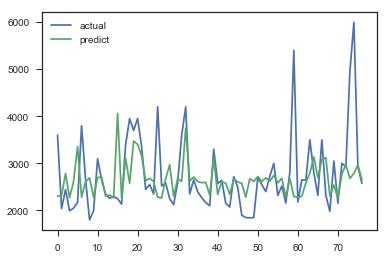

In [14]:
# Let's find out how we did.
y_predict = model.predict(eval_iter).asnumpy()

# RMSE is Root Mean Square Error.
rmse = np.sqrt(np.mean((y_predict - y_test)**2))
print('RMSE = {}'.format(rmse))

# MAPE is Median Absolute Percentage Error.
mape = 100 * np.median(np.abs(y_test - y_predict) / y_test)
print('MAPE = {}%'.format(round(mape, 2)))

# Accuracy is the opposite of MAPE.
accuracy = 100 - mape
print('Accuracy = {}%'.format(round(accuracy, 2)))

# Plot the predictions against the actual values.
plt.plot(np.array(y_test), label='actual')
plt.plot(y_predict, label='predict')
plt.legend()
plt.show()